In [197]:
import argparse
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from scripts.lib import get_standards_characteristics, load_target_minerals, get_formula, load_images

def get_variable_percent(formula, n, epsilon=.0001):
    elements = [
        {'element': e, 'min': m[0], 'max': m[1]}
        for e, m in formula.items()
    ]

    base = sum([e['min'] for e in elements])
    remainder = 1 - base
    element_remainders = [e['max'] - e['min'] for e in elements]

    v = np.hstack([
        np.random.uniform(0, e, (n, 1)) for e in element_remainders
    ])

    while remainder > 0:
        s = v.sum(axis=1, keepdims=True)
        v = (v/s)*remainder
        mask = v < element_remainders
        r = np.clip(v - element_remainders, 0, None)
        v = v - r
        v = v + (mask * (r.sum(axis=1) / mask.sum(axis=1)).reshape(-1, 1))
        if np.abs(remainder - v.sum(axis=1)).mean() < epsilon:
            break

    return [(e['element'], e['min']+v[:, i]) for i, e in enumerate(elements)]

def simulate_mineral(mineral, formula, standard_elements, n=5):
    if not isinstance(formula, list):
        formula = [formula]

    #elements = []
    #masses = []

    mineral_elements = {}
    def append(element, mass):
        if element in mineral_elements:
            mineral_elements[element] += mass
        else:
            mineral_elements[element] = mass

    for component in formula:
        if isinstance(component, str):
            for element, mass in get_formula(component, format="mass").items():
                append(element, np.ones(n)*mass)
        elif isinstance(component, dict):
            if 'quantity' in component:
                quantity = component['quantity']
                if isinstance(quantity, list):
                    quantity = np.random.randint(quantity[0], quantity[1]+1)
            else:
                quantity = 1

            for molecule, percent in get_variable_percent(component['components'], n):
                for element, mass in get_formula(molecule, format="mass").items():
                    append(element, percent*mass*quantity)
        else:
            raise ValueError(f"{str(component)} is not a recognized format")

    # Calculate mass percents
    df = pd.DataFrame(mineral_elements)
    df.columns = [f"{element}_mass" for element in df.columns]
    df['mass'] = df.sum(axis=1)
    for element in mineral_elements:
        df[f"{element}_percent"] = df[f"{element}_mass"]/df['mass']

    # Convert to intensities
    for element in standard_elements:
        e = standard_elements[element]
        df[element] = (
            e['intercept'] + np.random.normal(scale=e['noise'], size=n)
        )

        if f"{element}_percent" in df:
            df[element] += (
                e['coef']*df[f"{element}_percent"] +
                np.random.normal(scale=e['std'], size=n)
            )

        df[element] = np.clip(df[element], 0, None)


    '''mineral_elements = get_formula(component)
    for element, weight in mineral_elements.items():
        elements.append(element)
        masses.append(np.ones(n)*weight)'''

    df['mineral'] = mineral
    #df['formula'] = formula

    #return elements, masses
    return df





In [272]:
standards_dir = Path('challenge_data/dataset_1_opaques/standards/')
bits = 32
target_minerals_file = Path('challenge_data/dataset_1_opaques/target_minerals.yaml')
meteorite_dir = Path('challenge_data/dataset_1_opaques/obj1/')

characteristics = get_standards_characteristics(standards_dir, bits)
target_minerals = load_target_minerals(target_minerals_file)
#print(characteristics)
elements = list(characteristics.keys())
#

mineral_dfs = []
for mineral, formula in target_minerals.items():
    #print(mineral)

    df = simulate_mineral(mineral, formula, characteristics, 10000)
    #print(df.head())
    mineral_dfs.append(df[elements + ['mineral']])

df = pd.concat(mineral_dfs)

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}


In [261]:
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(-m, m, (100000, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'

df = pd.concat([df, unknown])

#print(len(df))
#print(df.head())



In [273]:
X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

print("Training Classifier...")
#model = RandomForestClassifier(100, max_depth=10, n_jobs=-1)

# Worked very well! I Think!
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

#from sklearn.mixture import GaussianMixture
#model = GaussianMixture(len(elements))

'''model = BaggingClassifier(
    RandomForestClassifier(5, max_depth=10, criterion='entropy'), 
    #DecisionTreeClassifier(max_depth=10, criterion='entropy'),
    n_estimators=20, 
    max_samples=.8, #max_features=.5,
    n_jobs=-1
)
model = AdaBoostClassifier(model, n_estimators=5)'''
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Classifier...
Training Accuracy: 0.9977045454545455
Testing Accuracy: 0.9973636363636363


In [274]:
proba = model.predict_proba(X_test)
cls = list(model.classes_)
i = [cls.index(c) for c in Y_test]
from sklearn.preprocessing import OneHotEncoder
o = OneHotEncoder(sparse=False)
l = o.fit_transform(np.array(i).reshape(-1, 1))
from sklearn.metrics import roc_curve, auc, roc_auc_score
roc_auc_score(l, proba)

/home/docmario/miniconda3/envs/haiku/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.999986189261969

In [275]:
mineral_thresholds = []
for i, c in enumerate(cls):
    #print(c)
    fpr, tpr, thresholds = roc_curve(l[:,i], proba[:,i])
    #print(thresholds[(tpr - fpr).argmax()])
    #print()
    mineral_thresholds.append((c, thresholds[(tpr - fpr).argmax()]))
mineral_thresholds

[('Albite', 0.9982692648113892),
 ('Anorthite', 0.9541289124881447),
 ('Diopside', 1.0),
 ('Kamacite', 0.9999999997041886),
 ('Millerite', 1.0),
 ('Olivine', 0.2935469793239855),
 ('Pentlandite', 1.0),
 ('Pyroxene', 0.12895322234399084),
 ('Taenite', 0.9998064245036482),
 ('Troilite', 1.0),
 ('Wollastonite', 0.9999908420659726)]

In [265]:
np.percentile(proba.max(axis=1), np.arange(0, 105, 5))

array([0.50034483, 0.99755036, 0.99995153, 0.99999928, 0.99999998,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [219]:
np.arange(0, 105, 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [218]:
proba.max(axis=1).min()

0.3982801729426313

In [119]:
(tpr - fpr).argmax(), thresholds[(tpr - fpr).argmax()]

(261, 0.173029014474665)

In [124]:
print(tpr[200], tpr[261], tpr[300])
print(fpr[200], fpr[261], fpr[300])
print(thresholds[200], thresholds[261], thresholds[300])

0.8978522786799371 0.9806181246726035 0.9874279727606077
0.0 0.004979403376940836 0.027386718573174595
0.7577743242803591 0.173029014474665 0.027463976684816337


In [255]:
model.theta_

array([[3.12432851e-01, 4.37999742e-01, 1.73846514e-01, 5.28819689e-01,
        6.65645011e-02, 3.26804618e+02, 8.84924704e-01],
       [6.65161024e+01, 4.44439850e-01, 1.71054916e-01, 5.30425579e-01,
        6.72544593e-02, 2.05200443e+02, 8.72251115e-01],
       [8.54644386e+01, 4.34480362e-01, 9.45586564e+01, 5.27112455e-01,
        6.63743339e-02, 2.63592945e+02, 8.82297046e-01],
       [3.05619499e-01, 2.78733583e+02, 1.73534774e-01, 3.13429141e+01,
        6.74979179e-02, 4.87879364e-01, 8.78162893e-01],
       [3.08885697e-01, 4.39471777e-01, 1.73386345e-01, 1.95960227e+02,
        7.43625294e+01, 4.89347044e-01, 8.67206496e-01],
       [3.14908467e-01, 9.70114509e+01, 1.25264709e+02, 5.21727976e-01,
        6.87761907e-02, 1.67288528e+02, 8.97126361e-01],
       [3.16130703e-01, 1.18529824e+02, 1.69441279e-01, 1.21047392e+02,
        4.60575119e+01, 4.83774910e-01, 8.93180758e-01],
       [3.13709120e-01, 7.25532375e+01, 9.18663769e+01, 5.20051305e-01,
        6.58606488e-02, 2

In [276]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
meteorite_df['proba'] = model.predict_proba(x).max(axis=1)

In [277]:
meteorite_df

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mineral,proba
0,0,25,26,25,15,65,0,0,0,332,9,Diopside,1.000000
1,1,45,15,17,12,26,0,0,0,229,12,Diopside,1.000000
2,2,51,11,12,9,5,0,0,0,262,8,Diopside,1.000000
3,3,62,5,12,8,5,0,5,0,278,12,Pyroxene,1.000000
4,4,80,4,6,5,6,0,0,0,313,9,Pyroxene,1.000000
5,5,75,4,6,7,7,3,3,0,312,6,Pyroxene,1.000000
6,6,73,6,4,5,22,0,0,0,302,5,Diopside,1.000000
7,7,49,0,0,12,37,0,0,0,324,7,Pyroxene,1.000000
8,8,44,3,0,10,78,0,2,0,328,4,Pyroxene,1.000000
9,9,23,5,10,17,120,0,0,0,270,5,Pyroxene,1.000000


In [86]:
meteorite_df[meteorite_df['proba'] < .4]

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mineral,proba
93,93,2,0,9,234,1,2,2,0,3,0,Unknown,0.352352
192,192,0,0,10,3,261,0,0,0,261,3,Pyroxene,0.332903
193,193,0,0,4,3,251,0,0,0,252,2,Olivine,0.346030
265,265,15,4,12,62,13,0,0,0,205,0,Unknown,0.382194
443,443,9,4,2,47,50,0,2,0,208,0,Pyroxene,0.397479
597,597,0,2,2,218,1,3,2,0,0,3,Unknown,0.377685
1320,1320,13,4,6,44,50,0,0,0,199,2,Unknown,0.372247
1424,1424,0,0,6,229,1,3,4,0,3,4,Unknown,0.368465
1444,1444,26,0,2,62,27,5,2,0,198,6,Olivine,0.380490
1811,1811,19,4,5,98,16,2,2,0,196,3,Olivine,0.356686


In [278]:
meteorite_df['mineral2'] = meteorite_df.apply(lambda r: "Unknown" if r['proba'] < .5 else r['mineral'], axis=1)

In [268]:
meteorite_df.groupby('mineral').apply(lambda g: (np.percentile(g['proba'], np.arange(0, 105, 10))*100).astype(int))

#np.percentile(meteorite_df['proba'], np.arange(0, 105, 5))

mineral
Albite              [49, 86, 98, 99, 99, 99, 99, 99, 99, 99, 99]
Anorthite           [50, 65, 81, 84, 87, 93, 98, 99, 99, 99, 99]
Diopside            [50, 61, 74, 82, 90, 95, 97, 99, 99, 99, 99]
Kamacite            [48, 96, 99, 99, 99, 99, 99, 99, 99, 99, 99]
Olivine             [35, 89, 96, 98, 99, 99, 99, 99, 99, 99, 99]
Pentlandite         [50, 62, 76, 85, 91, 94, 97, 99, 99, 99, 99]
Pyroxene            [38, 75, 92, 98, 99, 99, 99, 99, 99, 99, 99]
Taenite             [46, 85, 96, 99, 99, 99, 99, 99, 99, 99, 99]
Troilite            [50, 91, 98, 99, 99, 99, 99, 99, 99, 99, 99]
Unknown        [35, 99, 99, 99, 100, 100, 100, 100, 100, 100,...
dtype: object

In [279]:
meteorite_df.groupby('mineral').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,proba,mineral2
mineral,,,,,,,,,,,,,
Albite,705,705,705,705,705,705,705,705,705,705,705,705,705
Anorthite,41,41,41,41,41,41,41,41,41,41,41,41,41
Diopside,40365,40365,40365,40365,40365,40365,40365,40365,40365,40365,40365,40365,40365
Kamacite,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761
Olivine,105103,105103,105103,105103,105103,105103,105103,105103,105103,105103,105103,105103,105103
Pentlandite,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373
Pyroxene,50319,50319,50319,50319,50319,50319,50319,50319,50319,50319,50319,50319,50319
Taenite,2814,2814,2814,2814,2814,2814,2814,2814,2814,2814,2814,2814,2814
Troilite,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663


In [280]:
meteorite_df.groupby('mineral2').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mineral,proba
mineral2,,,,,,,,,,,,,
Albite,705,705,705,705,705,705,705,705,705,705,705,705,705
Anorthite,41,41,41,41,41,41,41,41,41,41,41,41,41
Diopside,40359,40359,40359,40359,40359,40359,40359,40359,40359,40359,40359,40359,40359
Kamacite,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761,21761
Olivine,105102,105102,105102,105102,105102,105102,105102,105102,105102,105102,105102,105102,105102
Pentlandite,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373,35373
Pyroxene,50317,50317,50317,50317,50317,50317,50317,50317,50317,50317,50317,50317,50317
Taenite,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813
Troilite,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663,5663


In [227]:
np.arange(0, 105, 10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [52]:
np.diag(df[elements].max(axis=0)/2)

array([[ 99.57998623,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        , 163.04899804,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        , 158.67065651,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 128.03067128,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         58.44224227,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 190.2455986 ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   4.80278442]])

In [62]:
n = 10000
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(0, m, (n, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
unknown

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,68.145545,76.650817,182.037691,239.985608,85.182156,366.197558,6.470639,Unknown
1,78.858170,13.516469,112.692233,176.805764,35.053068,227.743372,1.347436,Unknown
2,191.895588,264.027588,186.479640,153.879798,58.800643,236.756510,4.110706,Unknown
3,60.926614,255.009159,11.113949,214.341218,43.340483,286.329163,2.276628,Unknown
4,167.520099,236.312093,180.769454,254.509621,25.564706,368.859966,2.091677,Unknown
5,46.744887,292.385694,226.399052,85.169790,88.968012,21.829136,0.568123,Unknown
6,118.005149,182.279318,204.128134,103.008058,51.674334,257.635132,3.359041,Unknown
7,101.043671,135.365899,265.672809,112.675512,3.805568,95.883934,8.719912,Unknown
8,146.046983,121.602213,234.538795,238.868355,100.730780,334.522007,5.923120,Unknown
9,139.292701,187.856671,253.648126,111.167818,113.328217,343.278092,5.758593,Unknown


In [60]:
v.mean(axis=0)

array([100.37274865, 163.49989464, 158.62988911, 129.03376153,
        58.22183535, 190.32063038,   4.79648287])

In [56]:
unknown = pd.DataFrame(np.clip(
    np.random.multivariate_normal(
        #df[elements].mean(axis=0), 
        df[elements].max(axis=0)/2,
        #3*np.diag(df[elements].std(axis=0))
        #np.diag(df[elements].max(axis=0)/2),
        np.diag(np.ones(len(elements)))*2000,
        size=10000
    ),
    0, None
), columns=elements)
unknown['mineral'] = 'Unknown'
unknown

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,125.894997,71.124264,167.177873,188.640346,111.439820,195.184024,14.053050,Unknown
1,12.554975,144.884352,223.170363,169.031017,58.289294,185.088022,0.000000,Unknown
2,122.830390,197.249363,164.064438,102.149617,75.846883,231.228247,4.377436,Unknown
3,47.755433,154.993005,187.235856,89.567484,96.645593,143.208186,0.000000,Unknown
4,76.731919,184.270519,164.439063,77.243473,101.390445,173.859864,0.000000,Unknown
5,39.248587,175.879265,192.575032,73.728514,67.886425,157.657870,0.000000,Unknown
6,32.227132,167.960689,137.245618,177.787180,97.665986,204.041866,0.000000,Unknown
7,132.035216,152.256990,150.184503,107.648987,61.808969,189.348057,67.076451,Unknown
8,107.593921,130.001875,159.169067,101.804794,80.333163,142.186796,0.000000,Unknown
9,24.641328,146.215965,87.452755,197.910005,105.192072,221.836017,18.883113,Unknown


In [18]:
np.diag(df[elements].std(axis=0))

array([[ 51.06008949,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,  94.2268608 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  53.46664319,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  69.10283726,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         30.45481869,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 126.53957896,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.29214652]])

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}
Training Classifier...
Training Accuracy: 0.9999659090909091
Testing Accuracy: 0.9997727272727273


No handles with labels found to put in legend.


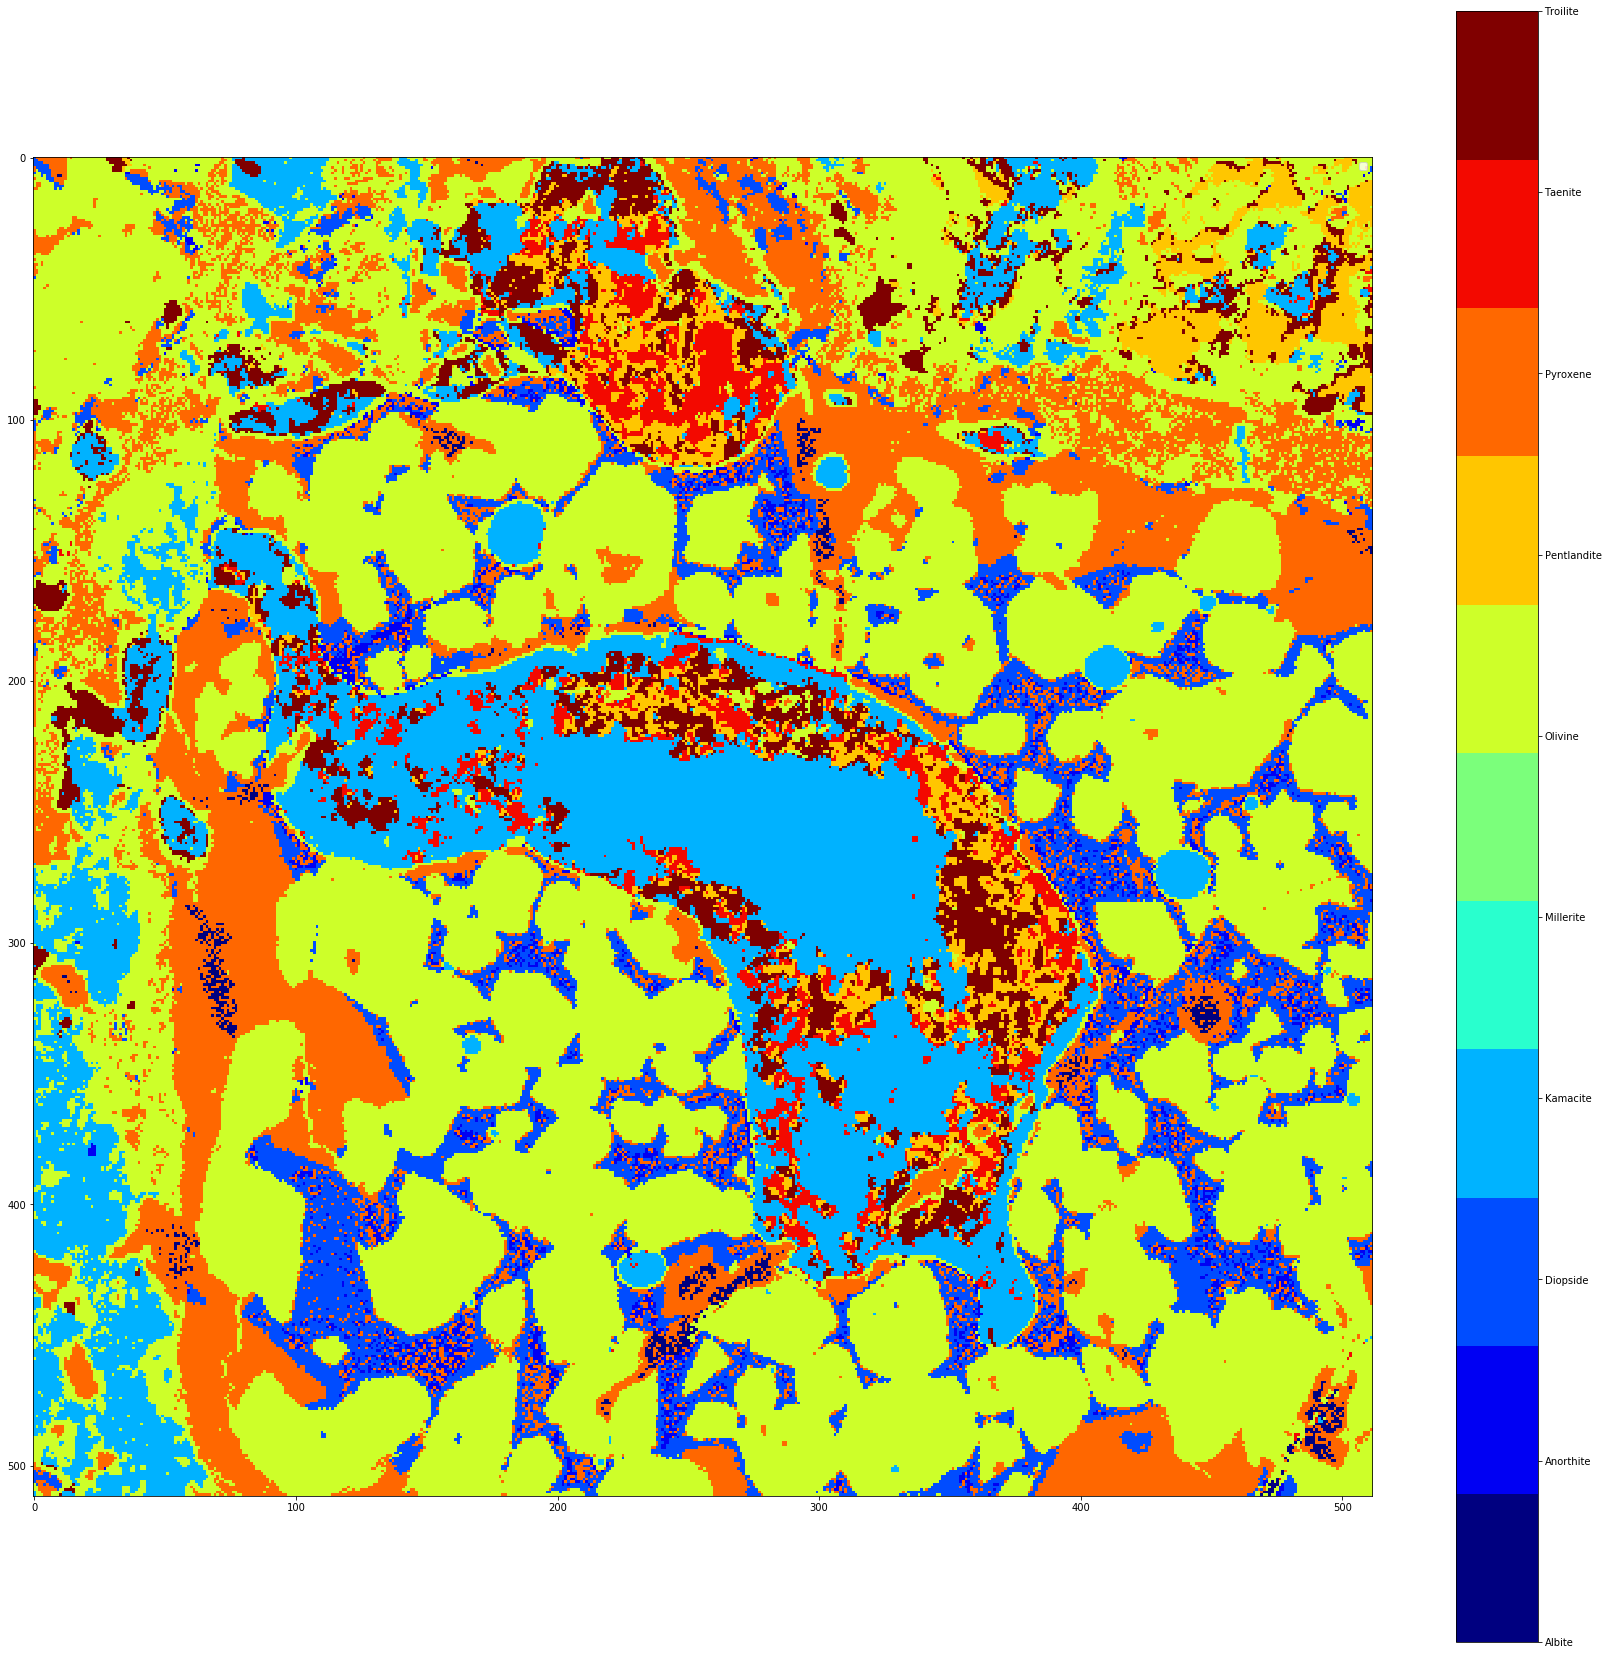

In [3]:


#print(len(df))
#print(df.head())

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

print("Training Classifier...")
model = RandomForestClassifier(100, max_depth=10, n_jobs=-1)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)

#print(meteorite_df.head(20))
results = meteorite_df.merge(
    pd.Series(
        model.classes_, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(30,30))
i = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(model.classes_))
)
cbar = figure.colorbar(i, ticks=range(len(model.classes_)))
cbar.ax.set_yticklabels(model.classes_)
ax.legend()

#figure.savefig('test.png')

In [35]:
meteorite_df['mineral'].unique()

array(['Pyroxene', 'Olivine', 'Pentlandite', 'Troilite', 'Kamacite',
       'Diopside', 'Anorthite', 'Albite', 'Taenite'], dtype=object)

In [36]:
model.classes_

array(['Albite', 'Anorthite', 'Diopside', 'Kamacite', 'Millerite',
       'Olivine', 'Pentlandite', 'Pyroxene', 'Taenite', 'Troilite',
       'Wollastonite'], dtype=object)

In [37]:
minerals = meteorite_df['mineral'].unique()
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

In [32]:
i.norm(1)

0.1111111111111111

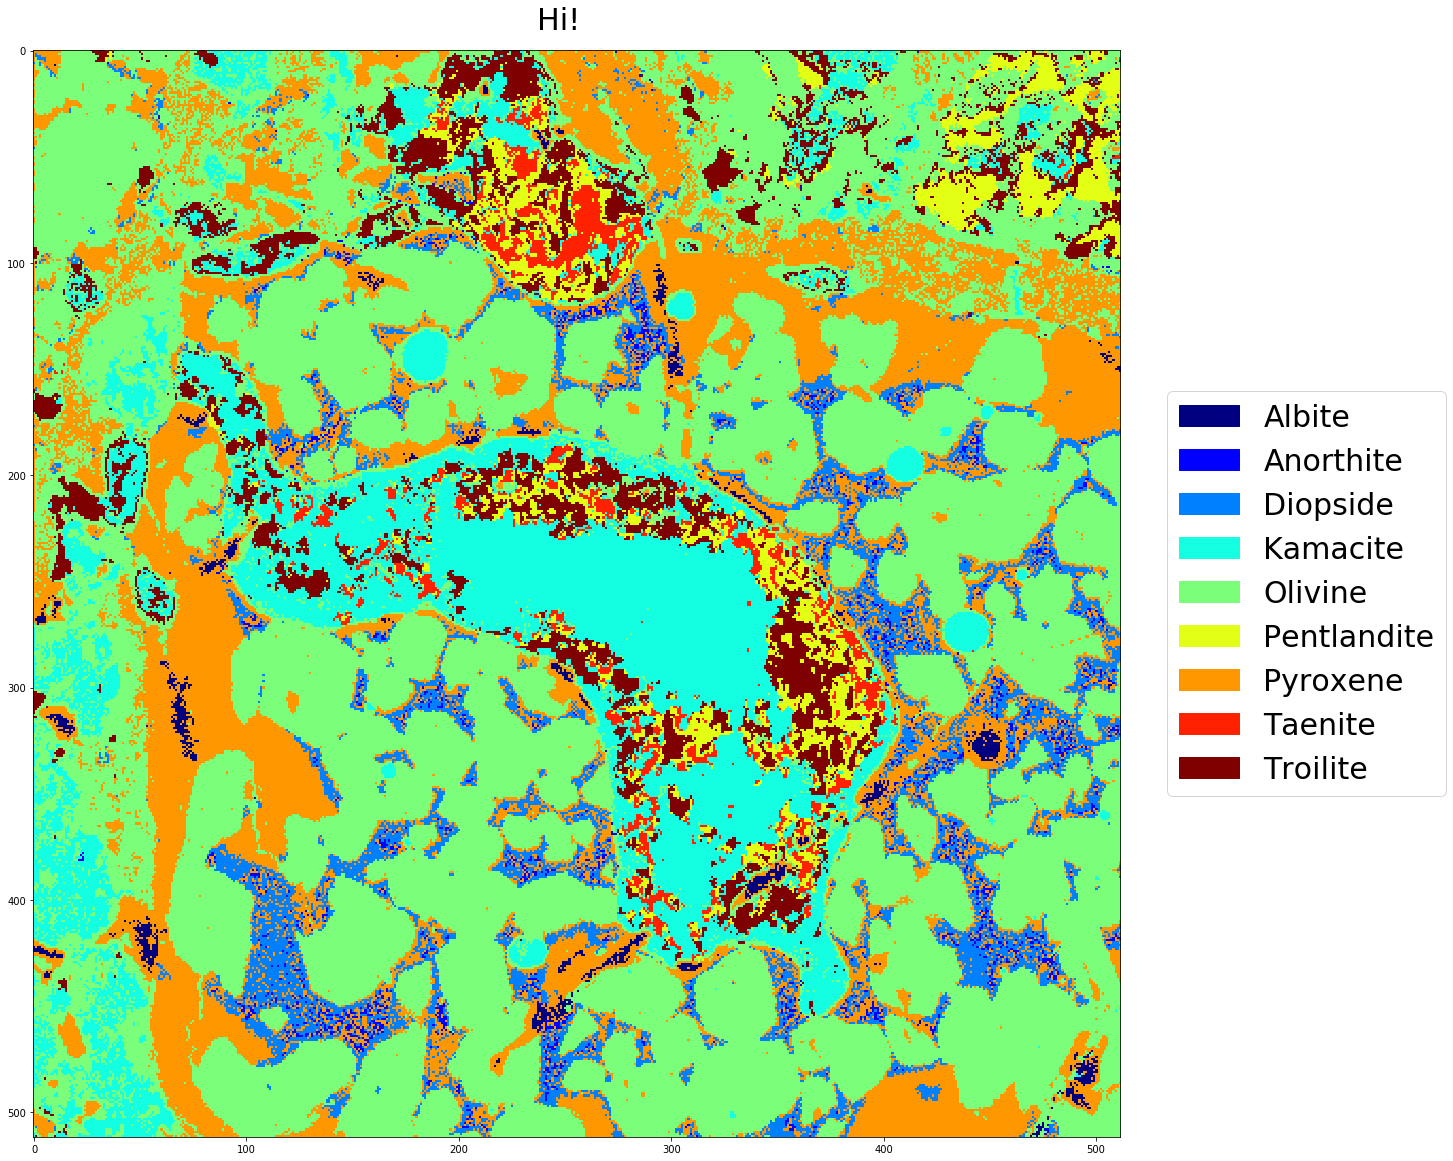

In [47]:
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

#cmap = plt.cm.get_cmap('jet', len(minerals))

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)

#cbar = figure.colorbar(i, ticks=range(len(model.classes_)))
#cbar.ax.set_yticklabels(model.classes_)
#ax.legend()

colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [ mpatches.Patch(color=colors[i], label=minerals[i]) for i in range(len(minerals)) ]
figure.suptitle('Hi!', fontsize=30, y=.91)
ax.legend(handles=patches, bbox_to_anchor=(1.3, .5, 0, 0), loc=5, borderaxespad=0., fontsize=30)

In [8]:
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=colors[i], label=model.classes_[i]) for i in range(len(model.classes_)) ]
patches